Loading spaCy...
✅ spaCy loaded
📊 Loaded 40432 reviews
   Fake: 20216
   Real: 20216

🔧 Extracting linguistic features...
⏳ This may take 5-10 minutes for 40k reviews...
✅ Linguistic features extracted

🔧 Extracting sentiment features...
✅ Sentiment features extracted

📊 Feature DataFrame: (5000, 17)
Columns: ['category', 'rating', 'label', 'text_', 'text_length', 'word_count', 'is_fake', 'text_clean', 'exclamation_count', 'question_count', 'capital_ratio', 'digit_count', 'unique_word_ratio', 'avg_word_length', 'sentence_count', 'sentiment_polarity', 'sentiment_subjectivity']

🔧 Adding metadata features...
✅ Metadata features added

📊 Visualizing feature distributions...


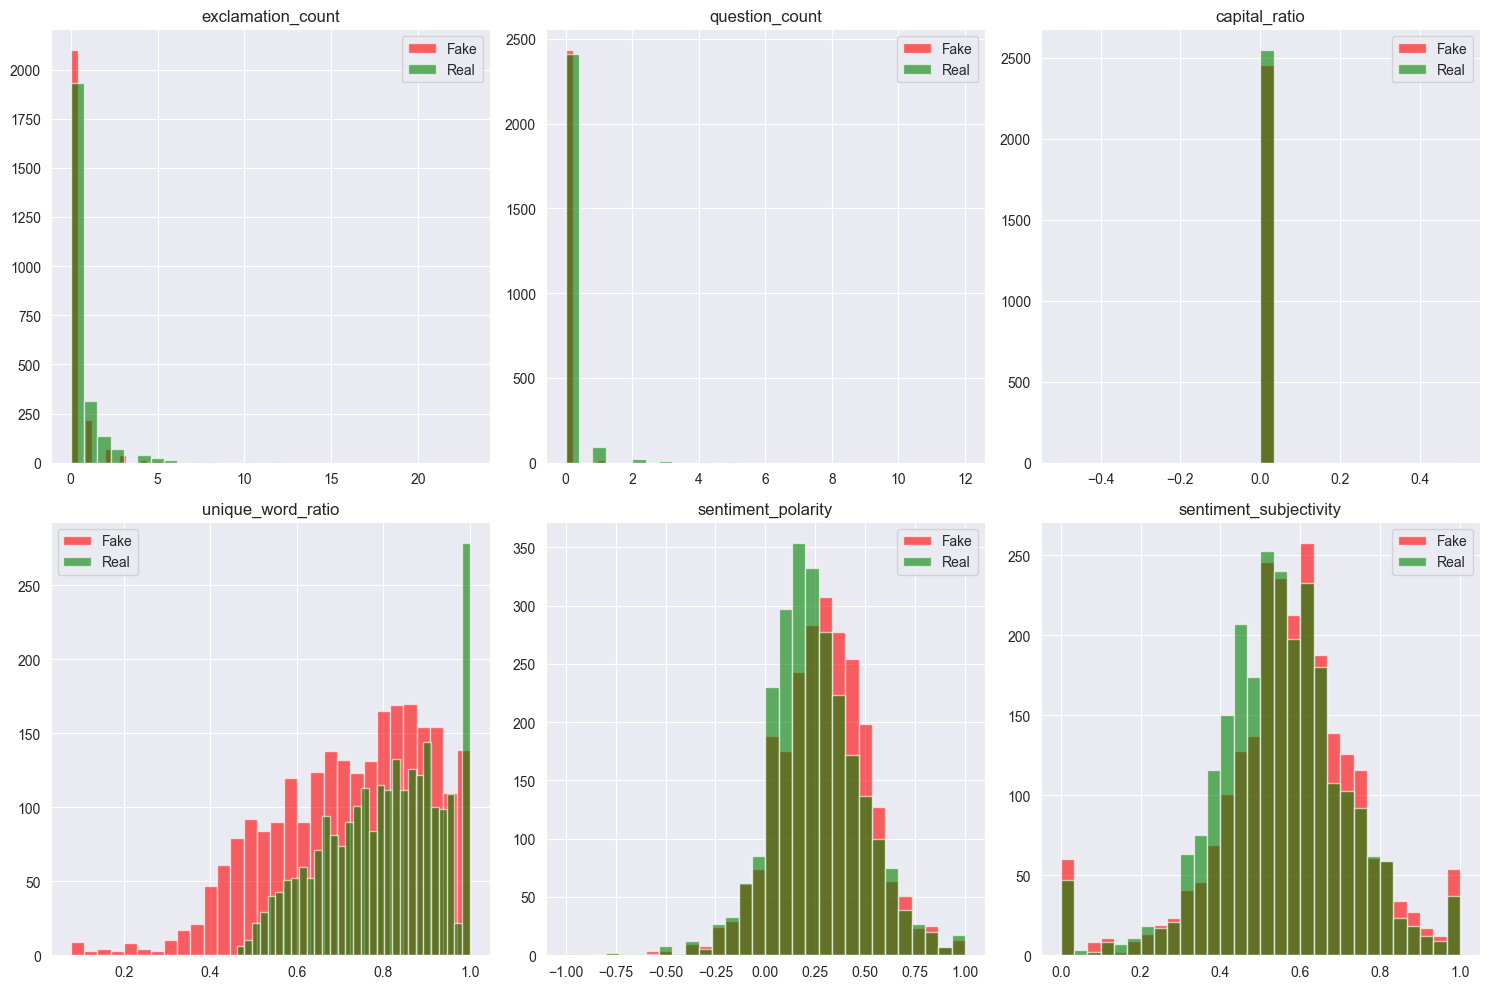


📊 Feature Correlation with is_fake:
is_fake                   1.000000
sentiment_polarity        0.077154
sentiment_subjectivity    0.070101
question_count           -0.095539
exclamation_count        -0.122884
unique_word_ratio        -0.240009
capital_ratio                  NaN
Name: is_fake, dtype: float64


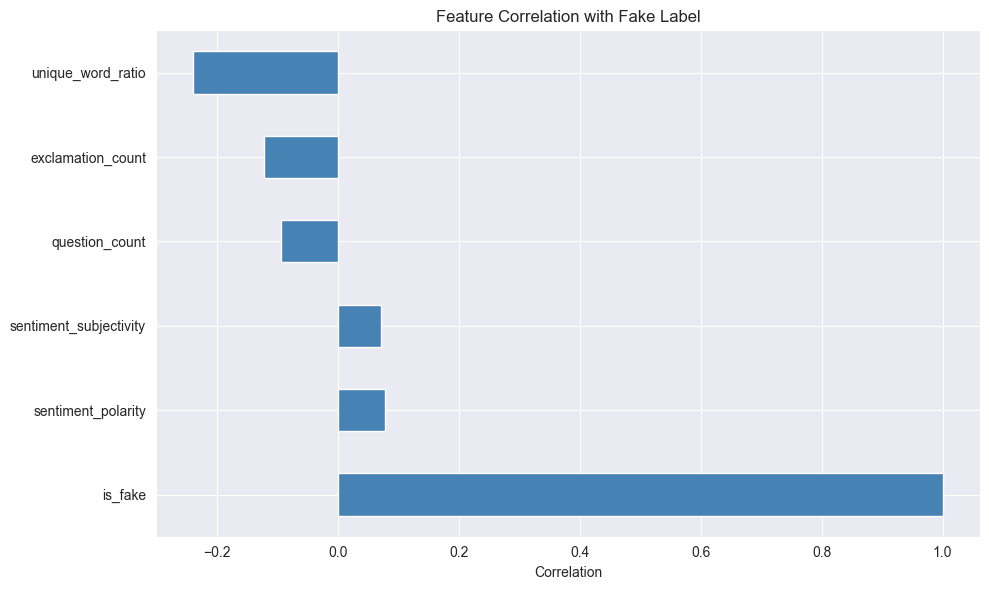


💾 Saving features...
✅ Saved to: ..\data\processed\reviews_with_features.csv
📊 Shape: (5000, 20)

🤖 Preparing data for ML...
✅ Data split:
   Training: 4000 samples
   Testing: 1000 samples
   Fake ratio in train: 49.08%
   Fake ratio in test: 49.10%

✅ Feature engineering complete!
📊 Ready for model training!


In [5]:
"""
03 - Feature Engineering for Fake Review Detection
"""

# %%
# Imports
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# NLP & ML
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords

# Download NLTK data
try:
    nltk.data.find('corpora/stopwords')
except:
    nltk.download('stopwords')

# Load spaCy
print("Loading spaCy...")
nlp = spacy.load('en_core_web_sm')
print("✅ spaCy loaded")

# %%
# Load data
df = pd.read_csv('../data/processed/reviews_cleaned.csv')
print(f"📊 Loaded {len(df)} reviews")
print(f"   Fake: {df['is_fake'].sum()}")
print(f"   Real: {(1-df['is_fake']).sum()}")

# %%
# === FEATURE ENGINEERING ===

def extract_linguistic_features(text):
    """Extract linguistic features from text"""

    if pd.isna(text) or text == "":
        return {
            'exclamation_count': 0,
            'question_count': 0,
            'capital_ratio': 0,
            'digit_count': 0,
            'unique_word_ratio': 0,
            'avg_word_length': 0,
            'sentence_count': 1
        }

    doc = nlp(text[:1000000])  # Limit for speed

    # Basic counts
    exclamation_count = text.count('!')
    question_count = text.count('?')

    # Capital letters ratio
    if len(text) > 0:
        capital_ratio = sum(1 for c in text if c.isupper()) / len(text)
    else:
        capital_ratio = 0

    # Digit count
    digit_count = sum(1 for c in text if c.isdigit())

    # Lexical diversity
    words = [token.text.lower() for token in doc if token.is_alpha]
    if len(words) > 0:
        unique_word_ratio = len(set(words)) / len(words)
        avg_word_length = np.mean([len(w) for w in words])
    else:
        unique_word_ratio = 0
        avg_word_length = 0

    # Sentence count
    sentence_count = len(list(doc.sents))

    return {
        'exclamation_count': exclamation_count,
        'question_count': question_count,
        'capital_ratio': capital_ratio,
        'digit_count': digit_count,
        'unique_word_ratio': unique_word_ratio,
        'avg_word_length': avg_word_length,
        'sentence_count': sentence_count
    }

def extract_sentiment_features(text):
    """Extract sentiment features"""

    if pd.isna(text) or text == "":
        return {
            'sentiment_polarity': 0,
            'sentiment_subjectivity': 0
        }

    blob = TextBlob(text)

    return {
        'sentiment_polarity': blob.sentiment.polarity,
        'sentiment_subjectivity': blob.sentiment.subjectivity
    }

# %%
# Extract features (this will take a few minutes)
print("\n🔧 Extracting linguistic features...")
print("⏳ This may take 5-10 minutes for 40k reviews...")

# Sample for faster processing (or use full dataset)
# Comment this line to use full dataset
df_sample = df.sample(n=5000, random_state=42)  # Use 5k for speed
# df_sample = df  # Uncomment to use full dataset

linguistic_features = df_sample['text_clean'].apply(extract_linguistic_features)
linguistic_df = pd.DataFrame(linguistic_features.tolist())

print("✅ Linguistic features extracted")

# %%
# Extract sentiment features
print("\n🔧 Extracting sentiment features...")

sentiment_features = df_sample['text_clean'].apply(extract_sentiment_features)
sentiment_df = pd.DataFrame(sentiment_features.tolist())

print("✅ Sentiment features extracted")

# %%
# Combine features
df_features = pd.concat([
    df_sample.reset_index(drop=True),
    linguistic_df,
    sentiment_df
], axis=1)

print(f"\n📊 Feature DataFrame: {df_features.shape}")
print(f"Columns: {list(df_features.columns)}")

# %%
# Add metadata features
print("\n🔧 Adding metadata features...")

# Rating extremity (fake reviews often 1 or 5 stars)
df_features['is_extreme_rating'] = df_features['rating'].isin([1, 5]).astype(int)

# Text length features
df_features['is_very_short'] = (df_features['word_count'] < 20).astype(int)
df_features['is_very_long'] = (df_features['word_count'] > 150).astype(int)

print("✅ Metadata features added")

# %%
# Visualize feature distributions
print("\n📊 Visualizing feature distributions...")

feature_cols = [
    'exclamation_count', 'question_count', 'capital_ratio',
    'unique_word_ratio', 'sentiment_polarity', 'sentiment_subjectivity'
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(feature_cols):
    fake_data = df_features[df_features['is_fake'] == 1][col]
    real_data = df_features[df_features['is_fake'] == 0][col]

    axes[idx].hist(fake_data, alpha=0.6, bins=30, label='Fake', color='red')
    axes[idx].hist(real_data, alpha=0.6, bins=30, label='Real', color='green')
    axes[idx].set_title(col)
    axes[idx].legend()

plt.tight_layout()
plt.show()

# %%
# Feature correlation with target
print("\n📊 Feature Correlation with is_fake:")
print("="*70)

correlation = df_features[feature_cols + ['is_fake']].corr()['is_fake'].sort_values(ascending=False)
print(correlation)

# Visualize
plt.figure(figsize=(10, 6))
correlation[:-1].plot(kind='barh', color='steelblue')
plt.title('Feature Correlation with Fake Label')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

# %%
# Save features
print("\n💾 Saving features...")

output_path = Path('../data/processed/reviews_with_features.csv')
df_features.to_csv(output_path, index=False)

print(f"✅ Saved to: {output_path}")
print(f"📊 Shape: {df_features.shape}")

# %%
# Prepare for ML
print("\n🤖 Preparing data for ML...")

# Select feature columns
feature_columns = [
    'text_length', 'word_count', 'avg_word_length',
    'exclamation_count', 'question_count', 'capital_ratio',
    'digit_count', 'unique_word_ratio', 'sentence_count',
    'sentiment_polarity', 'sentiment_subjectivity',
    'rating', 'is_extreme_rating', 'is_very_short', 'is_very_long'
]

X = df_features[feature_columns]
y = df_features['is_fake']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Data split:")
print(f"   Training: {len(X_train)} samples")
print(f"   Testing: {len(X_test)} samples")
print(f"   Fake ratio in train: {y_train.mean():.2%}")
print(f"   Fake ratio in test: {y_test.mean():.2%}")

# Save split indices for later
split_data = {
    'train_indices': X_train.index.tolist(),
    'test_indices': X_test.index.tolist()
}

import json
with open('../data/processed/train_test_split.json', 'w') as f:
    json.dump(split_data, f)

print("\n✅ Feature engineering complete!")
print("📊 Ready for model training!")